In [151]:
# RUN THIS CELL (0 Lines) #
import nbimporter
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import pandas as pd
import math

from scipy.linalg import eigh, cholesky
from scipy.stats import norm
from pylab import plot, show, axis, subplot, xlabel, ylabel, grid

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
# RUN THIS CELL  #

In [152]:
# RUN THIS CELL (0 Lines) #
# Helper Methods 
def getOnehottedDataset(dataset, features, prefixes):
# race, sex, sports, birth origin, education, educational prestige, criminal record, arrest record,
    onehotted_data = dataset.copy()
    onehotted_data = pd.get_dummies(onehotted_data, columns=features, prefix=prefixes)
    return onehotted_data

def graphSelectionRates(selected, candidates, protectedClass):
    selected_candidates = selected.copy()
    candidates_all = candidates.copy()
    raceIndxs = {"Caucasian": 0, "African-American": 1, "Asian": 2, "Hispanic": 3, "Other": 4 }
    sexIndxs = {"Male":0, "Female":1}
    
    if protectedClass == "race":
        features = [col for col in selected_candidates if col.startswith("race_")]
        race_selected = selected_candidates[features].idxmax(axis=1).str.replace('race_', '')
        race_all = candidates_all[features].idxmax(axis=1).str.replace('race_', '')
        
        candidates_all["Race"] = race_all
        selected_candidates["Race"] = race_selected

        numCandidates = candidates_all["Race"].value_counts()
        numQualified = selected_candidates["Race"].value_counts()

        selectionRate1 = numQualified["Caucasian"] / numCandidates["Caucasian"]
        selectionRate2 = numQualified["Asian"] / numCandidates["Asian"]
        selectionRate3 = numQualified["African-American"] / numCandidates["African-American"]
        selectionRate4 = numQualified["Hispanic"] / numCandidates["Hispanic"]
        
        print("The selection rate for " + "Caucasian" + "s: ",selectionRate1)
        print("The selection rate for " + "Asian" + "s: ", selectionRate2)
        print("The selection rate for " + "African-American" + "s: ",selectionRate3)
        print("The selection rate for " + "Hispanic" + "s: ",selectionRate4)
        
        y_pos = np.arange(4)
        performance = [selectionRate1, selectionRate2, selectionRate3, selectionRate4]
        plt.bar(y_pos, performance, align='center', alpha=0.5)
        plt.xticks(y_pos, ("Caucasian", "Asian", "African-American", "Hispanic"))
        plt.ylabel('Selection Rate')
        plt.title('Selection Rate Comparisons by Race')
        plt.show()
    elif protectedClass == "gender":
        
        features = [col for col in selected_candidates if col.startswith("gender_")]
        gender_selected = selected_candidates[features].idxmax(axis=1).str.replace('gender_', '')
        gender_all = candidates_all[features].idxmax(axis=1).str.replace('gender_', '')

        candidates_all["Gender"] = gender_all
        selected_candidates["Gender"] = gender_selected
        
        numCandidates = candidates_all["Gender"].value_counts()
        numQualified = selected_candidates["Gender"].value_counts()
        
        print(numCandidates)
        print(numQualified) 
        
        maleSelectionRate = numQualified["male"] / numCandidates["male"]
        femaleSelectionRate = numQualified["female"] / numCandidates["female"]
        print("The selection rate for " + "Male" + "s: ", maleSelectionRate)
        print("The selection rate for " + "Female" + "s: ", femaleSelectionRate)
        y_pos = np.arange(2)
        performance = [maleSelectionRate, femaleSelectionRate]
        plt.bar(y_pos, performance, align='center', alpha=0.5)
        plt.xticks(y_pos, ("Male", "Female"))
        plt.ylabel('Selection Rate')
        plt.title('Selection Rate Comparisons by Sex')
        plt.show()
    else:
        print("Try another protected type - gender or race")
        
def transformDatapointsToScale(candidates, selectedFeatures):
    df = candidates.copy()
    for feature in selectedFeatures:
        maximum = df[feature].max()
        df[feature] = df[feature].apply(lambda x: x / maximum)
    return df
# RUN THIS CELL #

# Milestone 2
## Exercise 1: Deepening our Approach

In the last milestone, we were exposed to basic automated algorithms, but our techniques were relatively naive! In the ranking model, your team simply came up with the weights.  And in your exposure to the nearest neighbor model, you quickly realized that problems with classification arise. So how do we "robustify" our automated approach.

The start is that we want more data on past employees! It is dubious to simply base our understanding of the importance of certain datapoints of candidates on a mere 25 employees. As such, since Sprawlmart is a massive corporation we actually have a dataset of 10000+ employees that you'll use to help train your models!  

### Task 1: Familiarizing ourselves with the massive dataset. 
Load the dataset below!

In [253]:
# READ THIS CELL (0 Lines) #
employees = pd.read_csv("../Employees_M2/employees_milestone2.csv")
candidates = pd.read_csv("../Candidates_M2/candidates_milestone2.csv")
print(employees.info())
print(candidates.info())
# READ THIS CELL #

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Names                         10000 non-null  object 
 1   Race                          10000 non-null  object 
 2   Gender                        10000 non-null  object 
 3   Sports                        10000 non-null  float64
 4   Birth Origin                  10000 non-null  object 
 5   Age                           10000 non-null  float64
 6   Zip                           10000 non-null  int64  
 7   Education                     10000 non-null  int64  
 8   GPA                           10000 non-null  float64
 9   Educational Prestige          10000 non-null  float64
 10  Years of Experience           10000 non-null  float64
 11  Soft Skills                   10000 non-null  float64
 12  Manager's Assessment Score    10000 non-null  float64
 13  Mi

#### Subtask 0: Take some time to use the tools below to begin understanding the nuance of this massive dataset. 

As an overview, the features are identical to the smaller sample of 25 employees that you saw in the last milestone. We have a bunch of features gathered on each employee including protected characteristics, and then we have some performance metrics of these employees.  The goal then is to try and build a model which given the features can effectively predict these metrics.  


##### The cell below takes a categorical feature like "Arrest Record" and displays how that distributes across a selected protected class like race. Just insert the categorical feature and attribute you want to examine.

In [254]:
# View the distributions of values of whatever feature you're interested in.
def displayDistributionOfFeature(dataset, feature, protectedAttribute):
    validAttributes = ["Race", "Sex", "Age", "Birth Origin"]
    if protectedAttribute not in validAttributes:
        print("Protected Attribute not valid")
        return
    groups = dataset.groupby([feature, protectedAttribute])
    
    print(dataset.groupby([feature, protectedAttribute]).size())
    
# INSERT CODE (2 Lines) #    
feature = "Criminal Record" # INSERT A FEATURE - GPA, Cultural Fit, etc. #
protectedAttribute = "Race" # INSERT A protected class - race, gender, etc. #
# INSERT CODE (2 Lines) #    

print("This is the distribution of values for the 10000 employees for the feature:", feature)
displayDistributionOfFeature(employees, feature, protectedAttribute)

This is the distribution of values for the 10000 employees for the feature: Criminal Record
Criminal Record  Race            
0.0              African-American    1260
                 Asian               1350
                 Caucasian           4950
                 Hispanic             900
                 Other                540
1.0              African-American     140
                 Asian                150
                 Caucasian            550
                 Hispanic             100
                 Other                 60
dtype: int64


##### The cell below enables you to scatterplot a feature against a particular metric to see the general relationship between a datapoint and objective metrics of performance for the employee. And each plot is colored by its specific protected attribute. 

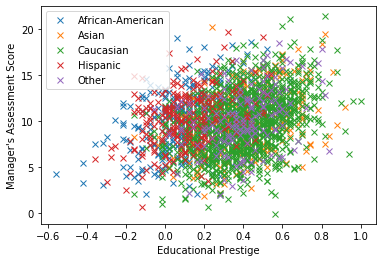

In [255]:
# Plot a particular value against a metric of performance you care about!
def plotFeatureToPerformance(dataset, feature, metric, protectedClass, val=None):
    
    df = dataset.copy()
    if val != None:
        if len(val) == 1:
            df = df.loc[(df[protectedClass] == val[0])]
        elif len(val) == 2:
            df = df.loc[(df[protectedClass]== val[0]) | (df[protectedClass]== val[1])]

    df = df[[feature, metric, protectedClass]]

    groups = df.groupby(protectedClass)

    for name, group in groups:
        plt.plot(group[feature], group[metric], marker="x", linestyle="", label=name)
        
    plt.xlabel(feature)
    plt.ylabel(metric)
    plt.legend()
    
feature = "Educational Prestige"# INSERT A FEATURE #
metric = "Manager's Assessment Score"# SELECT A METRIC #
protectedClass =  "Race"# INSERT A PROTECTED CLASS # 
plotFeatureToPerformance(candidates, feature, metric, protectedClass)
# plotFeatureToPerformance(candidates, feature, metric, protectedClass) 

##### The cell below enables you to choose a protected class, such as race, gender, and find the mean, median, min, and max values per group in that class for a given feature. This should help you see if there's a feature that seems to favor one group in a class over another.

In [256]:
# Find the mean, median among a particular protected class
def printStats(dataset, feature, protectedClass):
    
    if protectedClass == "race":
        races = ["African-American", "Asian", "Caucasian", "Hispanic", "Other"]
        df = dataset.copy()
        for race in races:
            selectedFeature = df.loc[(df["Race"] == race)][feature]
            print("The mean of " + feature + " for " + race + "s is", selectedFeature.mean())
            print("The median of " + feature + " for " + race + "s is", selectedFeature.median())
            print("The max value of " + feature + " for " + race + "s is", selectedFeature.max())
            print("The min value of " + feature + " for " + race + "s is", selectedFeature.min())
            print("")
            
    elif protectedClass == "gender":
        genders = ["male", "female"]
        df = dataset.copy()
        for gender in genders:
            selectedFeature = df.loc[(df["Gender"] == gender)][feature]
            print("The mean of " + feature + " for " + gender + "s is", selectedFeature.mean())
            print("The median of " + feature + " for " + gender + "s is", selectedFeature.median())
            print("The max value of " + feature + " for " + gender + "s is", selectedFeature.max())
            print("The min value of " + feature + " for " + gender + "s is", selectedFeature.min())
            print("")
            
printStats(candidates, "Soft Skills", "race")

The mean of Soft Skills for African-Americans is 2.012371428571428
The median of Soft Skills for African-Americans is 2.185
The max value of Soft Skills for African-Americans is 5.31
The min value of Soft Skills for African-Americans is -1.38

The mean of Soft Skills for Asians is 2.054559999999999
The median of Soft Skills for Asians is 2.19
The max value of Soft Skills for Asians is 5.57
The min value of Soft Skills for Asians is -1.4899999999999998

The mean of Soft Skills for Caucasians is 2.9672290909090924
The median of Soft Skills for Caucasians is 2.96
The max value of Soft Skills for Caucasians is 6.15
The min value of Soft Skills for Caucasians is 0.41

The mean of Soft Skills for Hispanics is 2.1156800000000002
The median of Soft Skills for Hispanics is 2.35
The max value of Soft Skills for Hispanics is 5.04
The min value of Soft Skills for Hispanics is -1.3199999999999998

The mean of Soft Skills for Others is 3.081066666666666
The median of Soft Skills for Others is 3.0949

##  Task 2: Running a Linear Regression Model. 

Ok, now that you've built up an intuition for the dataset, the relationship between some features and particular measures of performance, and potential biases, lets go ahead and attempt to deploy a simple model to select candidates as employees.  We'll start with linear regression, which you may already be familiar with.  

We'll need to 
* Select our Features, 
* Process the data
* Run the model
* Analyze Performance
* Then Iterate!

In [257]:
# RUN THIS CELL (0 Lines) #
# One-hotting the dataset for use
features = ["Race", "Gender", "Birth Origin", "Criminal Record", "Sports",
           "Arrest Record", "LinkedIn Score", "Responsible Social Media Use", "Undergraduate Degree"]
prefixes = ["race", "gender", "origin", "criminal", "sports", "arrest", "linkedin", 
           "socmedia", "degree"]
employees_race = employees["Race"]
candidates_race = candidates["Race"]
employees_processed = getOnehottedDataset(employees, features, prefixes)
employees_processed["Race"] = employees_race
candidates_processed = getOnehottedDataset(candidates, features, prefixes)
candidates_processed["Race"] = candidates_race
# candidates_processed.info()
# RUN THIS CELL #

##### Feature & Metric Selection

In [258]:
# Insert CODE (2 Lines) #
selectedFeatures = [
#      "Education", "Educational Prestige", "Years of Experience",
#     "Years of Experience", "GPA", "Education", "Educational Prestige", 
    "Soft Skills", "Years of Experience", "Educational Prestige"
]
metric = "Manager's Assessment Score"
# Insert CODE #

##### Normalize data and split into Train & Test
Typically when we run a model, we want to ensure that its behavior is generalizable to do this invoke a train test split to try and ensure that model is not overfitting to its input. While the concept is not too important for us in this exact instance, just know that in general when you're applying ML algorithms out in the wild it is absolutely essential to split your data in a train and test split so you have a semblance of knowledge as to whether your model can generalize!

- The first cell block splits our dataset into a train-test (75/25) split.

In [259]:
# RUN THIS CELL (0 Lines) #
# Again good 'ol feature selection!
# Currently just a divide by max - normalization scheme...
employees_scaled = transformDatapointsToScale(employees_processed, selectedFeatures)
# employees_scaled = employees_processed
candidates_scaled = transformDatapointsToScale(candidates_processed, selectedFeatures)
# candidates_scaled = candidates_processed

y = employees_scaled[metric]
X = employees_scaled.drop([metric], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=50)

X_train_selectedFeatures = X_train[selectedFeatures].copy()
X_test_selectedFeatures = X_test[selectedFeatures].copy()
# RUN THIS CELL #
# RUN THIS CELL #

#### Subtask: 
##### Model Training

In [260]:
# RUN THIS CELL (0 Lines) #
def printRegressionStats(y_true, y_pred):
    print("MSE value is", mean_squared_error(y_true, y_pred))
    print("R^2 value is", r2_score(y_true, y_pred))

model = LinearRegression()
trained_model = model.fit(X_train_selectedFeatures, y_train)
# RUN THIS CELL #

##### Initial Results

In [261]:
# RUN THIS CELL (0 Lines) #
# Let's analyze the results ==>
y_pred = trained_model.predict(X_train_selectedFeatures)
print("The results on the training set")
printRegressionStats(y_train, y_pred)
print("")
print("The results on the test set")
y_test_pred = trained_model.predict(X_test_selectedFeatures)
printRegressionStats(y_test, y_test_pred)
y_test_pred
# RUN THIS CELL #
# RUN THIS CELL (0 Lines) #

The results on the training set
MSE value is 4.29190736230186
R^2 value is 0.5696427596520366

The results on the test set
MSE value is 4.151500208336706
R^2 value is 0.6077923646856448


array([ 9.37218007,  8.83056508,  9.68277215, ..., 14.38441612,
       12.98664438, 12.49635216])

##### Ranking results and selecting candidates

In [262]:
# RUN THIS CELL (0 Lines) #
# Ranking the individuals
def rankJobCandidates(candidates):
    candidates = candidates.copy()
    candidates = candidates.sort_values(["Scores"], ascending=False)
    return candidates

def selectCandidates(candidates, percentile):
    numCandidates = math.floor(len(candidates) * percentile)
    return candidates.iloc[:numCandidates]

percentile = .10

candidate_data = candidates_scaled[selectedFeatures].copy()
candidate_pred = trained_model.predict(candidate_data)
candidates_scaled["Scores"] = candidate_pred
candidates_ranked = rankJobCandidates(candidates_scaled)
candidatesSelected = selectCandidates(candidates_ranked, percentile)
# RUN THIS CELL (0 Lines) #
candidatesSelected

,Names,Age,Zip,Education,GPA,Educational Prestige,Years of Experience,Soft Skills,Manager's Assessment Score,Military Tenure,...,linkedin_Very Good,socmedia_Bad,socmedia_Good,degree_Engineering,degree_Humanities,degree_None,degree_Quantitative,degree_Sciences,Race,Scores
2492,Larry Brown,38.0,94087,5,3.25,0.46,1.000000,0.790244,18.25,0.0,...,1,0,1,0,0,0,1,0,Caucasian,18.980873
2329,Frank Stone,42.0,94603,5,3.64,0.50,0.888889,0.816260,17.29,0.0,...,1,0,1,0,0,0,1,0,Caucasian,18.215972
2009,Amy Martin,38.0,95002,5,3.73,0.46,0.888889,0.808130,16.10,1.5,...,0,0,1,0,1,0,0,0,Caucasian,18.080537
817,Jerry Sonoski,38.0,94040,5,4.54,0.60,0.703704,1.000000,20.36,0.0,...,0,0,1,0,1,0,0,0,Caucasian,17.799826
1083,Walter Davis,29.0,94611,5,4.19,0.74,0.703704,0.897561,17.90,1.0,...,0,0,1,1,0,0,0,0,Caucasian,17.543153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,Richard Leasure,33.0,94304,2,3.11,0.38,0.518519,0.622764,11.41,0.0,...,0,0,1,1,0,0,0,0,Asian,13.531719
1883,Paris Chittum,38.0,94030,5,2.40,0.32,0.629630,0.466667,10.05,0.0,...,0,0,1,0,1,0,0,0,Asian,13.525436
325,Judith Simpson,36.0,94131,5,3.36,0.40,0.555556,0.552846,12.54,0.0,...,0,0,1,0,1,0,0,0,Caucasian,13.519828
1814,George Woodman,35.0,94539,4,2.88,0.00,0.666667,0.534959,11.64,0.0,...,1,0,1,1,0,0,0,0,Caucasian,13.519660


Race
African-American     25
Asian                36
Caucasian           154
Hispanic             15
Other                20
dtype: int64
The selection rate for Caucasians:  0.112
The selection rate for Asians:  0.096
The selection rate for African-Americans:  0.07142857142857142
The selection rate for Hispanics:  0.06


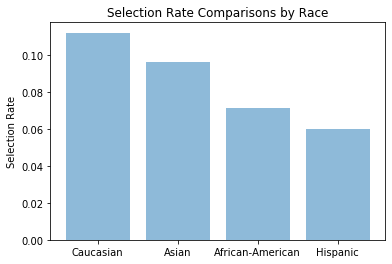

In [263]:
print(candidatesSelected.groupby(["Race"]).size())
graphSelectionRates(candidatesSelected, candidates_scaled, "race")

## Subtask: Tweaking the model. 
 - For your own fun, feel free to use other features and test model performance using those different features.  Report if you were able to see noticeable gains in improvement or rectifications of bias. 
 - Your team will get a chance to build/tweak a model on Exercise 3 so no need to try and get this model perfect.

## Task 3: Differential Validity 

Ok in the previous exercise we tried to investigate the problem of differential validity through considering how certain skews in the data might make it such that our design of the model's weights could be helpful for one group of individuals but not another.  

Now that we've trained a model, we can actually investigate the weights for the selected features and consider differential validity problems more concretely. 

As of now, recall that the highest (10%) scoring candidates will get selected, and that the scores are calculated by multiplying the learned weights of each selected feature is multiplied with the candidate's feature values and adding them up. So positive weights indicate a positive relation with the resulting score and negative weights indicate a negative relation. 

Take a look at the learned weights of the model using the features and metric you chose by running the cell below.

In [264]:
# RUN THIS CELL (1 Line) #
# Checking the weights
coeff_values = list(model.coef_)
# features = list(model.classes_)
# assert(len(coeff_values) == len(features))
featureToValues = {selectedFeatures[x] : coeff_values[x] for x in range(len(selectedFeatures))}
print(featureToValues)
# RUN THIS CELL #

{'Soft Skills': 5.582341992195241, 'Years of Experience': 9.001642688711613, 'Educational Prestige': 2.2512611249467227}


##### Questions:
- By analyzing the model weights, how can you examine whether your model exhibits a potential differential validity problem? 
- Try running the model on different sets of features and performance metrics, by analyzing the weights and using the tools in task 1, is there a differential validity problem in a particular model, given this dataset?